In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# 顯示中文與數字負號
import matplotlib.font_manager as fm
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf" 
cht = fm.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf') 
plt.rcParams['axes.unicode_minus']=False

--2020-06-12 14:05:56--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  24.7MB/s    in 0.4s    

2020-06-12 14:05:56 (24.7 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



2014年損益96、2015年損益-154、2016年損益-146、2017年損益-34、2018年損益-35、2019年損益-215、2020年迄今損益133
2014年迄今損益-355

2014年損益-88、2015年損益-359、2016年損益-575、2017年損益-20、2018年損益-277、2019年損益-604、2020年迄今損益176
2014年迄今損益-1747

2014年損益100、2015年損益-11、2016年損益-291、2017年損益-64、2018年損益-172、2019年損益-243、2020年迄今損益-198
2014年迄今損益-879



(<matplotlib.axes._subplots.AxesSubplot at 0x7fd24d0ab668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd24cb06e48>)

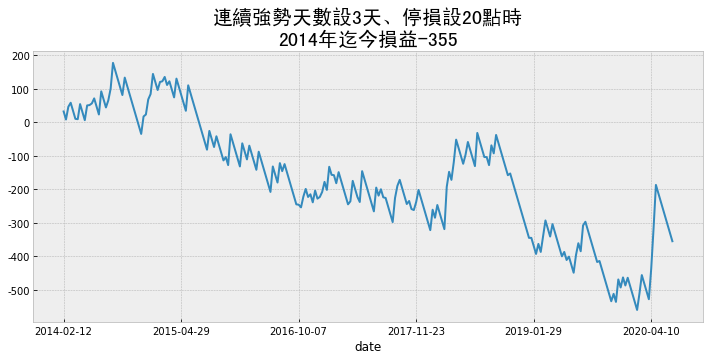

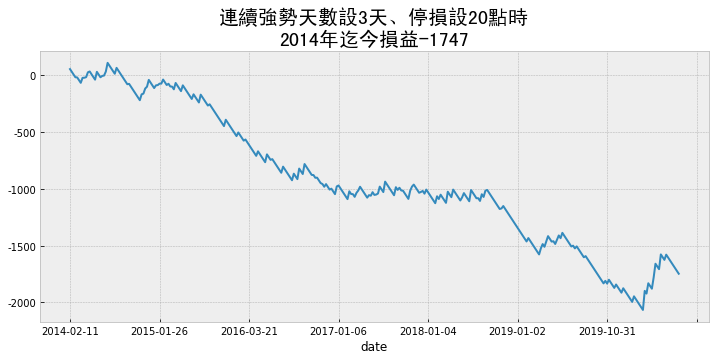

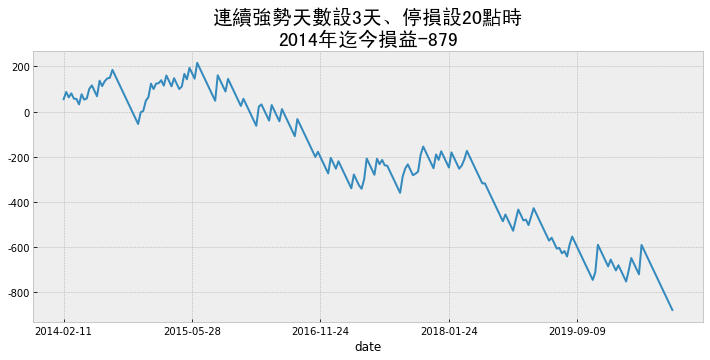

In [2]:
def backtest(label, continuity, stp):
    '''
    讀取github上預先抓好的台指期日k交易明細csv檔
    從 2014-01-02 到 2020-06-12 共 1576天
    函式第一個參數label有三個選項「high, low, close」對應你想查看「最高價、最低價、收盤價」哪一個的連續趨勢
    函式第二個參數continuity為想指定連續趨勢長達幾天。值越高會使符合交易條件的天數越少
    函式第三個參數stp為想設幾點停損。一但停損，當天的損益即記錄該值(尚不含交易成本)且不再繼續交易
    '''
    df = pd.read_csv('https://raw.githubusercontent.com/MaxChenCMC/TX_intraday_long_only_strategy_regression/master/tx00.csv',index_col = 0)
    df['label_high'] = np.where( (df['High'].shift(1) > df['High'].shift(2)).rolling(continuity).sum() >= continuity, 1, 0)
    df['label_low'] = np.where( (df['Low'].shift(1) > df['Low'].shift(2)).rolling(continuity).sum() >= continuity, 1, 0) 
    df['label_close'] = np.where( (df['Close'].shift(1) > df['Close'].shift(2)).rolling(continuity).sum() >= continuity, 1, 0)
    if label == 'high':
        df = df[df['label_high'] == 1]
    elif label == 'low':
        df = df[df['label_low'] == 1]
    elif label == 'close':
        df = df[df['label_close'] == 1]
    
    # 交易成本：手續費2點、滑價2點，總共4點
    df['PnL'] = 0
    for i in range(len(df)):
        if df['Open'][i] - df['Low'][i] >= stp:
            df['PnL'][i] = -stp - 4  # 當日低點超越停損範圍，則損益記錄為停損點數加上交易成本
        else:
            df['PnL'][i] = (df['Close'][i] - df['Open'][i]) -4 # 當日收盤價出場，扣掉開盤價的買進成本後，還要扣掉交易成本
    
    pnl_2014 = df['PnL']['2014':'2015'].sum()
    pnl_2015 = df['PnL']['2015':'2016'].sum()
    pnl_2016 = df['PnL']['2016':'2017'].sum()
    pnl_2017 = df['PnL']['2017':'2018'].sum()
    pnl_2018 = df['PnL']['2018':'2019'].sum()
    pnl_2019 = df['PnL']['2019':'2020'].sum()
    pnl_2020 = df['PnL']['2020':].sum()
    print(f'2014年損益{pnl_2014}、2015年損益{pnl_2015}、2016年損益{pnl_2016}、2017年損益{pnl_2017}、2018年損益{pnl_2018}、2019年損益{pnl_2019}、2020年迄今損益{pnl_2020}')
    res = df['PnL'].sum()
    print(f'2014年迄今損益{res}\n')    
    plt.figure(figsize=(12,5))
    plt.title(f'連續強勢天數設{continuity}天、停損設{stp}點時\n2014年迄今損益{res}',fontproperties= cht, fontsize=20)
    return df['PnL'].cumsum().plot()

# 挑選連續3天「昨日高過前日高 vs 昨日低沒破前日低 vs 昨日收盤高過前日收盤」三種情況才進場做多，且停損都抓20點，看各過去幾年的績效
backtest('high',3, 20), backtest('low',3, 20), backtest('close',3, 20)

# 以上三種情況，報酬都很不理想，不過「昨日高過前日高」的虧損是最少的。
## 稍微調整一下參數，停損從115點起算，每加5點就看一次結果，至150點為止

2014年損益222、2015年損益120、2016年損益24、2017年損益4、2018年損益-107、2019年損益-566、2020年迄今損益366
2014年迄今損益63

2014年損益222、2015年損益120、2016年損益9、2017年損益4、2018年損益-117、2019年損益-571、2020年迄今損益361
2014年迄今損益28

2014年損益222、2015年損益120、2016年損益27、2017年損益4、2018年損益-127、2019年損益-576、2020年迄今損益356
2014年迄今損益26

2014年損益222、2015年損益120、2016年損益17、2017年損益4、2018年損益-83、2019年損益-581、2020年迄今損益351
2014年迄今損益50

2014年損益222、2015年損益120、2016年損益32、2017年損益4、2018年損益-88、2019年損益-586、2020年迄今損益346
2014年迄今損益50

2014年損益222、2015年損益120、2016年損益27、2017年損益4、2018年損益-93、2019年損益-591、2020年迄今損益341
2014年迄今損益30

2014年損益222、2015年損益120、2016年損益22、2017年損益4、2018年損益-59、2019年損益-596、2020年迄今損益336
2014年迄今損益49

2014年損益222、2015年損益120、2016年損益17、2017年損益4、2018年損益-59、2019年損益-601、2020年迄今損益331
2014年迄今損益34



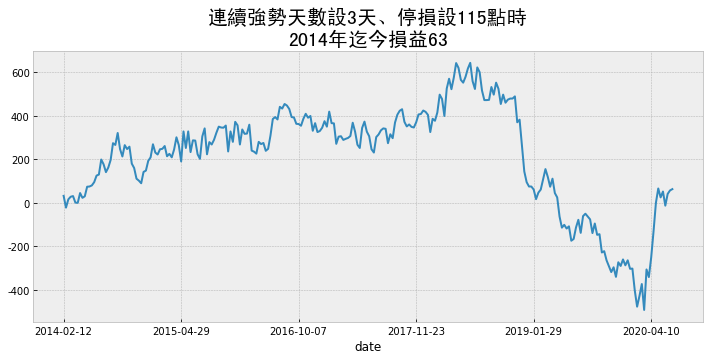

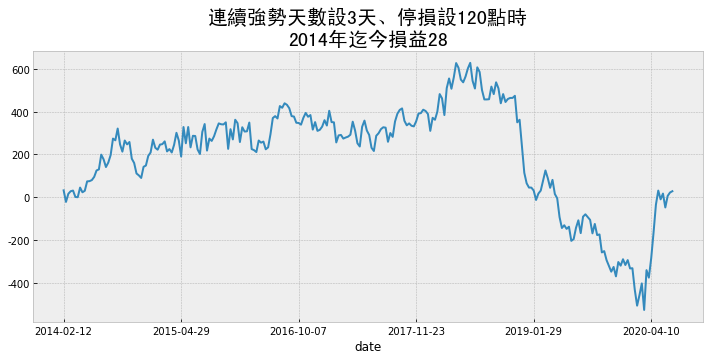

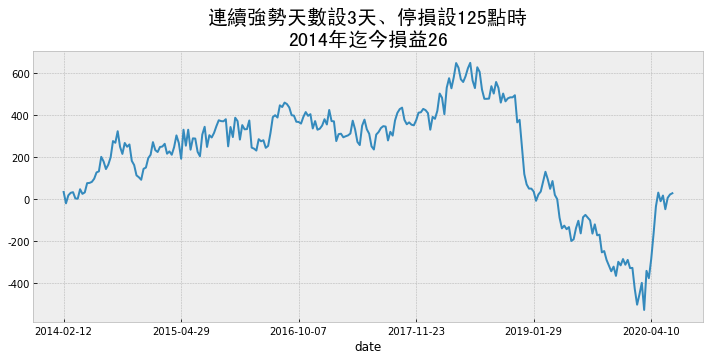

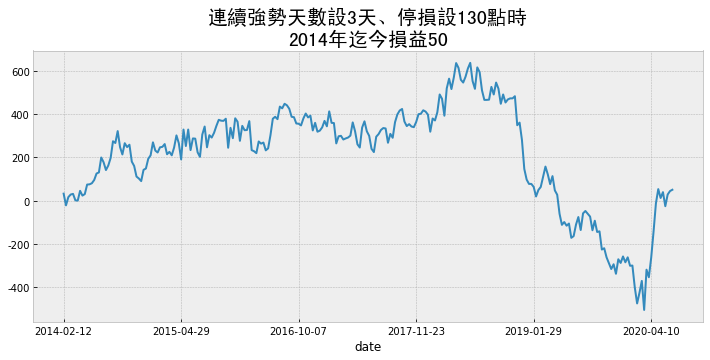

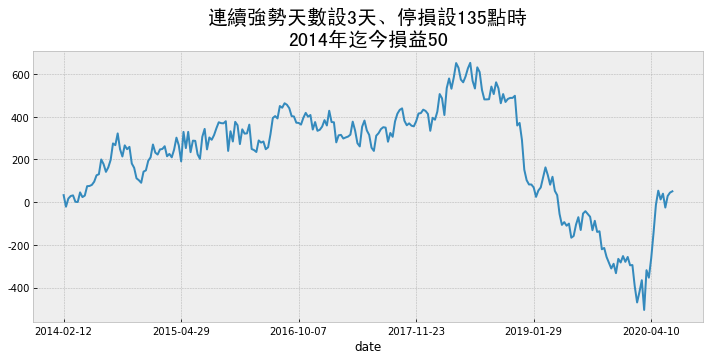

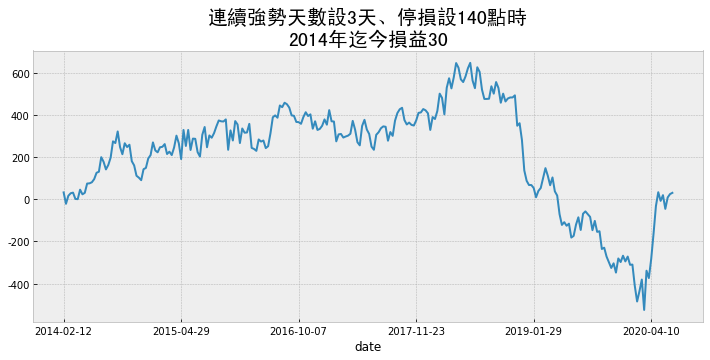

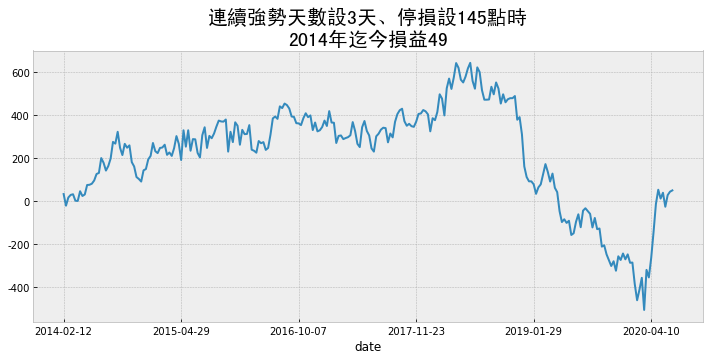

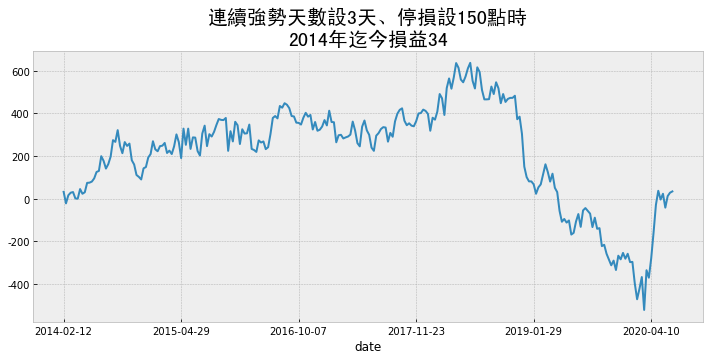

In [3]:
for i in range(115,151,5):
    backtest('high',3, i)